In [1]:
import numpy as np

import sewpy # SEXtractor wrapper

import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization.wcsaxes import SphericalCircle
from matplotlib.patches import Ellipse

import warnings
warnings.filterwarnings("ignore") # remove all warning

%matplotlib inline

In [2]:
def runsextractor(image_file, detect_thresh=3.5, analysis_thresh=3.0):
    params = ['NUMBER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_BEST', 'FLUXERR_BEST', 'BACKGROUND', 
              'THRESHOLD', 'FLUX_MAX', 'XMAX_IMAGE', 'YMAX_IMAGE', 'XPEAK_IMAGE', 'YPEAK_IMAGE', 'ALPHAPEAK_J2000', 
              'DELTAPEAK_J2000', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_SKY', 'DELTA_SKY', 'ALPHA_J2000', 'DELTA_J2000']

    config = {"DETECT_THRESH":detect_thresh, "ANALYSIS_THRESH":analysis_thresh}

    sew = sewpy.SEW(params=params, config=config)

    out = sew(image_file)
    data = out["table"]
    
    #ra, dec, flux, label = data['ALPHA_J2000'], data['DELTA_J2000'], data['FLUX_MAX'], data['NUMBER'].astype('int')
    
    return data #, ra, dec, flux, label, data

In [3]:
def find_beam(hdr):
    major = hdr["BMAJ"] # in degree
    minor = hdr["BMIN"]
    pa = hdr["BPA"] # position angle
    
    return (major, minor, pa)

def find_center_and_scale(hdr):
    obsra, obsdec = hdr["OBSRA"], hdr["OBSDEC"]
    scale_ra, scale_dec = hdr["CDELT1"], hdr["CDELT2"] # deg/pixel
    # center_pixel_ra, center_pixel_dec = hdr["CRPIX1"], hdr["CRPIX2"]
    npxl_ra, npxl_dec = hdr["NAXIS1"], hdr["NAXIS2"] 
    
    return obsra, obsdec, scale_ra, scale_dec, npxl_ra, npxl_dec  # in deg

In [4]:
def plot_singleimage(filename, 
                     add_pb=True, PB=18, 
                     add_scale=True, scalearcsec=5, scaletitle='5"', 
                     add_center_marker=True, center_marker='X',
                     add_title=True, title="",
                     add_source_label=False, sources=None,
                     savefig=True, figname="figure.pdf"):
    
    hdu = fits.open(filename)[0]
    
    imgdata = hdu.data
    vmax = imgdata.max()
    
    # coordinate
    wcs = WCS(hdu.header, naxis=2) # naxis -> hack for fits from CASA (data shape problem)

    # image
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=wcs)
    ax.imshow(imgdata[0][0], vmin=0.0, vmax=vmax, origin='lower', cmap='gray_r')
    
    # axis label and ticks
    ra = ax.coords[0]
    dec = ax.coords[1]
    ra.set_axislabel("RA (J2000)", minpad=0.8)
    dec.set_axislabel("Dec (J2000)", minpad=-1.0)
    ra.set_major_formatter('hh:mm:ss.s')
    
    # Find image center and scale
    obsra, obsdec, scale_ra, scale_dec, npxl_ra, npxl_dec = find_center_and_scale(hdu.header)
    
    # Primary Beam
    if add_pb:
        pb = SphericalCircle((obsra*u.deg, obsdec*u.deg), 0.5*PB*u.arcsec, 
                             transform=ax.get_transform('icrs'),
                             edgecolor='red', facecolor='none')
        ax.add_patch(pb)
    
    # Scale bar
#     if add_scale:
#         pos_scale_ra  = 
#         pos_scale_dec =
        
    # Beam
    major, minor, pa = find_beam(hdu.header)
    beam_ra  = obsra  - 0.5*scale_ra*npxl_ra - major
    beam_dec = obsdec - 0.5*scale_dec*npxl_dec + major
    beam = Ellipse((beam_ra, beam_dec), major, minor, 90.0-pa, # BPA relative pos
                   transform=ax.get_transform('icrs'),
                   edgecolor='none', facecolor='black')
    ax.add_patch(beam)
    
    
    # Center label
    if add_center_marker:
        ax.scatter(obsra, obsdec, marker=center_marker, 
                   transform=ax.get_transform('icrs'),
                   edgecolor="red", facecolor="none", s=100)
    
    # Source label
    if add_source_label:
        ra = sources['ALPHA_J2000']
        dec = sources['DELTA_J2000']
        flux = sources['FLUX_MAX']
        label = sources['NUMBER'].astype('int')
        
        for i, so in enumerate(sources):
            ax.scatter(ra[i], dec[i], marker='s', 
                       transform=ax.get_transform('icrs'),
                       edgecolor="black", facecolor="none", s=250, label=label)
        
        for i, lbl in enumerate(label):
            ax.text(ra[i], dec[i]-0.0005, lbl, color='black', size=12, 
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.get_transform('icrs'))
    
    # Title inside image
    if add_title:  
        fonttitle = {'family': 'serif', 'color':  'black', 'weight': 'medium', 'size': 12}
        ax.text(0.05, 0.95, title, fontdict=fonttitle,
                horizontalalignment='left', verticalalignment='center', 
                transform=ax.transAxes)
    
    if savefig:
        plt.savefig(figname, dpi=300, bbox_inches="tight")

In [5]:
imgfile = "./images/uid___A002_X969646_X1aa8.ms.split.cal-CALIBRATE_BANDPASS-J0501-0159.ms.self3.substracted.cont.image.fits"
#imgfile = "./images/concat2.ms.cont.image.fits"

In [6]:
data = runsextractor(imgfile)
data['NUMBER', 'ALPHA_J2000', 'DELTA_J2000', 'FLUX_MAX', 'FLUX_BEST', 'BACKGROUND', 'THRESHOLD']

Ouch, SExtractor complains :
b''


NUMBER,ALPHA_J2000,DELTA_J2000,FLUX_MAX,FLUX_BEST,BACKGROUND,THRESHOLD
,deg,deg,ct,ct,ct,ct
int64,float64,float64,float64,float64,float64,float64
1,75.3000234,-1.990202,0.0003581623,0.01117613,-1.543025e-06,0.000288476
2,75.3035378,-1.9877912,0.0006883366,0.04321004,-3.981624e-06,0.000288476


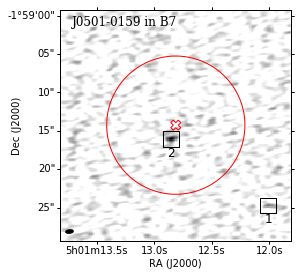

In [7]:
plot_singleimage(imgfile, title="J0501-0159 in B7", add_source_label=True, sources=data) # data[:1]

### Primary Beam correction for Flux

In [8]:
def pb_attenuation_corr(center_ra, center_dec, PB, ra, dec, flux):
    """
    Primary Beam Correction using Gaussian
    Note: PB in arcsec
    """
    center = SkyCoord(center_ra, center_dec, unit=(u.deg, u.deg), frame='icrs')
    source = SkyCoord(ra, dec, unit=(u.deg, u.deg), frame='icrs')
    
    theta_from_the_center = source.separation(center).arcsec # in arcsec
    # print(theta_from_the_center)
    
    # devide by gaussian function
    corrected_flux = flux / np.exp(-np.log(2) * 4 * (theta_from_the_center/PB)**2)
    
    return corrected_flux

In [9]:
hdu = fits.open(imgfile)[0]
obsra, obsdec, scale_ra, scale_dec, npxl_ra, npxl_dec = find_center_and_scale(hdu.header)

ra_source = []
dec_source = [] 
flux_source = []
label_source = []
for i,d in enumerate(data):
    ra_source.append(data[i]['ALPHA_J2000'])
    dec_source.append(data[i]['DELTA_J2000'])
    flux_source.append(data[i]['FLUX_MAX'])
    label_source.append(data[i]['NUMBER'].astype('int'))

# print(ra_source, dec_source, flux_source)

# PB Corr
PB = 18.0
corrected_flux = []
for i, ra in enumerate(ra_source):
    corrected_flux.append(pb_attenuation_corr(obsra, obsdec, PB, ra_source[i], dec_source[i], flux_source[i]))

print("Number \t RA & Dec                        Flux Max \t Corrected Flux (PB attenuation)")
for i, ra in enumerate(ra_source):
    c = SkyCoord(ra_source[i]*u.deg, dec_source[i]*u.deg, frame='icrs')
    rahmsstr = c.ra.to_string(u.hour)
    str(rahmsstr)
    decdmsstr = c.dec.to_string(u.degree, alwayssign=True)
    str(decdmsstr)
    coord = rahmsstr + ' ' + decdmsstr
    
    print(label_source[i], "\t", coord, "  ", flux_source[i], "\t", corrected_flux[i])

Number 	 RA & Dec                        Flux Max 	 Corrected Flux (PB attenuation)
1 	 5h01m12.0056s -1d59m24.7272s    0.0003581623 	 0.0031753241488459405
2 	 5h01m12.8491s -1d59m16.0483s    0.0006883366 	 0.0007096099982380298
